In [1]:
from importlib import reload
import sys
import pickle
import numpy as np 
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.ioff()
%matplotlib inline
import seaborn as sns
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pybedtools
from joblib import Parallel, delayed
from tqdm import tqdm
import time
from matplotlib_venn import venn3, venn3_circles
from upsetplot import from_contents
from upsetplot import UpSet
import fastcluster
from matplotlib_venn import venn3

# Data directories

In [2]:
genome_dir = '/home/braunger/masterthesis/data/genome_data/'
epigenome_dir = '/home/braunger/masterthesis/data/regulatory_data/regulatory_data_IMR90/'
processed_epigenome_data_dir = '/home/braunger/masterthesis/save/processed_regulatory_marks/processed_epigenome_data_IMR90/'
processed_hic_data_dir = '/home/braunger/masterthesis/save/processed_hic_data/processed_hic_data_IMR90/final_BP250000_intraKR_interINTERKR/'
PCs_dir = '/home/braunger/masterthesis/save/processed_hic_data/processed_hic_data_IMR90/intrachromosomal_PCs/'

In [3]:
cell_type = 'IMR90'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'

# Determine active and inactive regions

### Correlations of PCs on observed/expected vs. correlation matrix

In [8]:
chr_list =  np.arange(1,22+1)
for chrom in chr_list:
    PCs = pd.read_csv(PCs_dir+'PCs_chr'+str(chrom)+'.csv', header=0, index_col = 0)
    PCs_corr = pd.read_csv(PCs_dir+'PCs_corr_chr'+str(chrom)+'.csv', header=0, index_col = 0)

    #Calculate correlation of PCs
    corr_PC1 = np.corrcoef(PCs.iloc[:, 0], PCs_corr.iloc[:, 0])[0,1]
    corr_PC2 = np.corrcoef(PCs.iloc[:, 1], PCs_corr.iloc[:, 1])[0,1]

    print("Correlation PC1 on chrom "+str(chrom)+": "+str(corr_PC1))
    print("Correlation PC2 on chrom "+str(chrom)+": "+str(corr_PC2))
    print()

Correlation PC1 on chrom 1: 0.7122977383035322
Correlation PC2 on chrom 1: -0.6215931808335279

Correlation PC1 on chrom 2: 0.9648528042859013
Correlation PC2 on chrom 2: -0.26004678346430965

Correlation PC1 on chrom 3: 0.9564463467927918
Correlation PC2 on chrom 3: -0.21609017533310296

Correlation PC1 on chrom 4: 0.9738535368437462
Correlation PC2 on chrom 4: 0.8781294049836399

Correlation PC1 on chrom 5: 0.9532821891248779
Correlation PC2 on chrom 5: -0.8476667726381475

Correlation PC1 on chrom 6: 0.9714863168223561
Correlation PC2 on chrom 6: -0.6883179196577687

Correlation PC1 on chrom 7: 0.9628453772382489
Correlation PC2 on chrom 7: -0.572365753960918

Correlation PC1 on chrom 8: 0.9635207303616852
Correlation PC2 on chrom 8: 0.4701525490459389

Correlation PC1 on chrom 9: -0.2687930496414726
Correlation PC2 on chrom 9: -0.27871644117087796

Correlation PC1 on chrom 10: 0.9715785442332517
Correlation PC2 on chrom 10: -0.6475028785647512

Correlation PC1 on chrom 11: 0.970144

### Load epigenomic data

In [12]:
# Helper function for loading principal component data
def get_PCs(PCs_dir, chrom, df_chipseq_norm, input_type):
    # load PCs
    if input_type == "correlation":
        PCs = pd.read_csv(PCs_dir+'PCs_corr_chr'+str(chrom)+'.csv', header=0, index_col = 0)
    else: 
        PCs = pd.read_csv(PCs_dir+'PCs_chr'+str(chrom)+'.csv', header=0, index_col = 0)
    
    # calculate correlation of the two PCs to the RNA-seq
    corr_PC1 = np.corrcoef(PCs.iloc[:, 0], df_chipseq_norm.loc['RNAseq'])[0,1]
    corr_PC2 = np.corrcoef(PCs.iloc[:, 1], df_chipseq_norm.loc['RNAseq'])[0,1]
    
    # choose between PC1 and PC2 the one with higher correlation and correct to positive correlation with RNA-seq
    if abs(corr_PC1) >= abs(corr_PC2):
        if corr_PC1 < 0:
            PC = -1 * PCs.iloc[:, 0]
        else:
            PC = PCs.iloc[:, 0]
    else:
        if corr_PC2 < 0:
            PC = -1 * PCs.iloc[:, 1]
        else:
            PC = PCs.iloc[:, 1]

    
    # create pd DataFrame
    PC = pd.DataFrame(PC).T
    if input_type == "correlation": 
        PC.index = ["PC_corr"]
    else:
        PC.index = ["PC"]
    PC.columns = df_chipseq_norm.columns
    return(PC)

In [13]:
# collect normalized epigenomic data across all chromosomes into one dataframe
df_all_norm = pd.DataFrame()
for chrom in chr_list:
    # get feature matrix per chromosome
    df_chipseq_norm = pd.read_csv(processed_epigenome_data_dir+'features_matrix_chr'+str(chrom)+'_norm.csv', header=0, index_col = 0)
    df_chipseq_norm.columns = 'chr_'+str(chrom)+'_loc_'+np.array(df_chipseq_norm.columns)
    # get PCs on intrachromosomal hic data
    PC = get_PCs(PCs_dir, chrom, df_chipseq_norm, "normal")
    # get PCs on correlation matrix of intrachromosomal hic data
    PC_corr = get_PCs(PCs_dir, chrom, df_chipseq_norm, "correlation")
    # add PC as feature
    df_chipseq_complete = pd.concat([df_chipseq_norm, PC, PC_corr], axis = 0)
    # Concatenate to data for previous chromosomes
    df_all_norm = pd.concat([df_all_norm, df_chipseq_complete],axis=1)

### Correlation between features

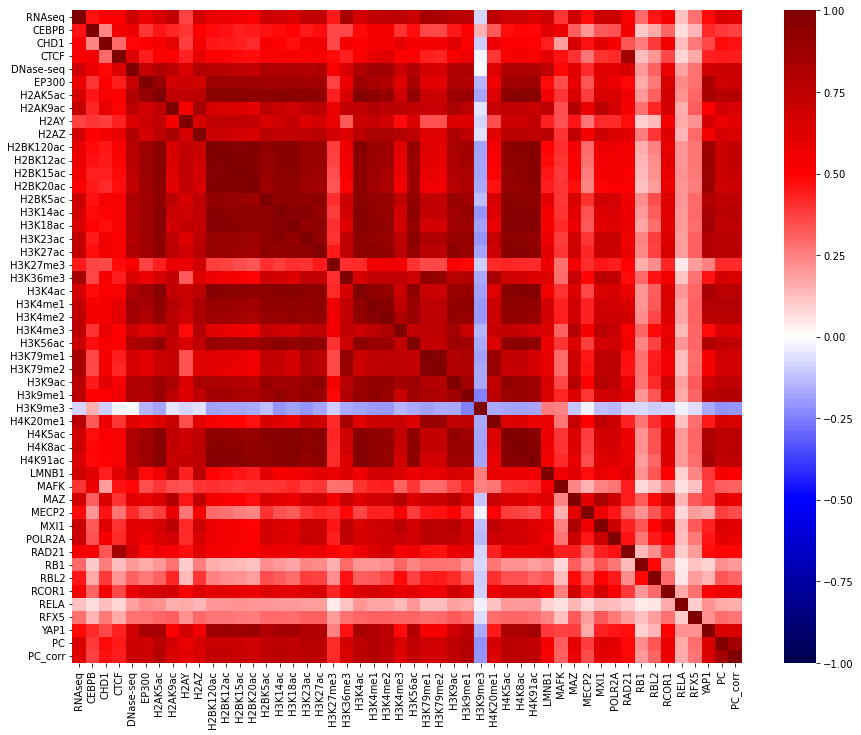

In [14]:
plt.figure(figsize = (15,12))
sns.heatmap(df_all_norm.T.corr(), cmap = "seismic", vmin = -1, vmax = 1)
plt.show()

In [17]:
# Correlation between PC based on observed/expected vs based on correlation matrix
df_all_norm.T.corr().loc["PC", "PC_corr"]

0.8545156586867189

### Correlation to RNAseq

In [18]:
df_all_norm.T.corr().loc["RNAseq", "PC"]

0.6421189359968067

In [19]:
df_all_norm.T.corr().loc["RNAseq", "PC_corr"]

0.6239776082007279